# Prediction Challenge Part 2: Report

## How likely is one to download your app?

In [86]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

### I) Cleaning and Inspecting the Dataset

In [87]:
app = pd.read_csv('googleplaystore.csv')
app.isna().sum()

Unnamed: 0           0
App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Getting rid of Nan values

In [88]:
app['Rating'].fillna(0, inplace = True)
app['Type'].fillna('Unknown', inplace = True)
app['Content Rating'].fillna('Unknown', inplace = True)
app['Android Ver'].fillna('Unknown', inplace = True)
app.isna().sum()

Unnamed: 0        0
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       0
dtype: int64

In [89]:
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


#### Rating: Taking a look at the Rating column:

In [90]:
print(app.Rating.dtype)
print(app.Rating.unique())

float64
[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   0.   4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]


#### Reviews: Converting Reviews to integer

In [91]:
print(app.Reviews.dtype)
print(app.Reviews.unique())
print(app.Reviews.describe())

object
['159' '967' '87510' ... '603' '1195' '398307']
count     10841
unique     6002
top           0
freq        596
Name: Reviews, dtype: object


In [92]:
app['Reviews'] = app['Reviews'].apply(lambda x: str(x))

In [93]:
def converting_m(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    return value

Here M represents million hence converting the M into a number

In [94]:
app['Reviews'] = app['Reviews'].apply(converting_m)

In [95]:
app['Reviews'] = app['Reviews'].apply(lambda x: int(x))

#### Size: Converting the letters in Size column:

Doing the same thing as above only with k being kilobyte we convert it to megabyte and remove the letters k and m from the numbers, we also deal with 'Varies with device'

In [96]:
def converting_size(size):
    if 'k' in size:
        return float(size.replace('k', '')) / 1024
    elif 'M' in size:
        return float(size.replace('M', ''))
    elif 'Varies with device' in size:
        return np.nan
app['Size'] = app['Size'].apply(converting_size)
app.rename(columns={'Size' : 'Size(Mb)'}, inplace=True)
print(app['Size(Mb)'].dtype)
print(app['Size(Mb)'].unique())

float64
[1.90000000e+01 1.40000000e+01 8.70000000e+00 2.50000000e+01
 2.80000000e+00 5.60000000e+00 2.90000000e+01 3.30000000e+01
 3.10000000e+00 2.80000000e+01 1.20000000e+01 2.00000000e+01
 2.10000000e+01 3.70000000e+01 2.70000000e+00 5.50000000e+00
 1.70000000e+01 3.90000000e+01 3.10000000e+01 4.20000000e+00
 7.00000000e+00 2.30000000e+01 6.00000000e+00 6.10000000e+00
 4.60000000e+00 9.20000000e+00 5.20000000e+00 1.10000000e+01
 2.40000000e+01            nan 9.40000000e+00 1.50000000e+01
 1.00000000e+01 1.20000000e+00 2.60000000e+01 8.00000000e+00
 7.90000000e+00 5.60000000e+01 5.70000000e+01 3.50000000e+01
 5.40000000e+01 1.96289062e-01 3.60000000e+00 5.70000000e+00
 8.60000000e+00 2.40000000e+00 2.70000000e+01 2.50000000e+00
 1.60000000e+01 3.40000000e+00 8.90000000e+00 3.90000000e+00
 2.90000000e+00 3.80000000e+01 3.20000000e+01 5.40000000e+00
 1.80000000e+01 1.10000000e+00 2.20000000e+00 4.50000000e+00
 9.80000000e+00 5.20000000e+01 9.00000000e+00 6.70000000e+00
 3.00000000e+01 

#### Installs: Converting the Installs column to numbers only:

In [97]:
app['Installs'] = app['Installs'].apply(lambda x: x.replace('+' , '') if '+' in str(x) else x)
app['Installs'] = app['Installs'].apply(lambda x: x.replace(',' , '') if ',' in str(x) else x)
app['Installs'] = app['Installs'].apply(lambda x: np.nan if 'Free' in str(x) else x)

app['Installs'] = pd.to_numeric(app['Installs'], errors='coerce')

print(app['Installs'].dtype)
print(app['Installs'].unique())

float64
[1.e+04 5.e+05 5.e+06 5.e+07 1.e+05 5.e+04 1.e+06 1.e+07 5.e+03 1.e+08
 1.e+09 1.e+03 5.e+08 5.e+01 1.e+02 5.e+02 1.e+01 1.e+00 5.e+00 0.e+00
    nan]


#### Type: Checking Type Column

In [98]:
app['Type'] = app['Type'].apply(lambda x: np.nan if '0' in str(x) else x)
print(app.Type.dtype)
print(app.Type.unique())

object
['Free' 'Paid' 'Unknown' nan]


#### Price: converting them to float while removing/converting unnecessary values

In [99]:
app.Price.unique()

array(['0', '$4.99 ', '$3.99 ', '$6.99 ', '$1.49 ', '$2.99 ', '$7.99 ',
       '$5.99 ', '$3.49 ', '$1.99 ', '$9.99 ', '$7.49 ', '$0.99 ',
       '$9.00 ', '$5.49 ', '$10.00 ', '$24.99 ', '$11.99 ', '$79.99 ',
       '$16.99 ', '$14.99 ', '$1.00 ', '$29.99 ', '$12.99 ', '$2.49 ',
       '$10.99 ', '$1.50 ', '$19.99 ', '$15.99 ', '$33.99 ', '$74.99 ',
       '$39.99 ', '$3.95 ', '$4.49 ', '$1.70 ', '$8.99 ', '$2.00 ',
       '$3.88 ', '$25.99 ', '$399.99 ', '$17.99 ', '$400.00 ', '$3.02 ',
       '$1.76 ', '$4.84 ', '$4.77 ', '$1.61 ', '$2.50 ', '$1.59 ',
       '$6.49 ', '$1.29 ', '$5.00 ', '$13.99 ', '$299.99 ', '$379.99 ',
       '$37.99 ', '$18.99 ', '$389.99 ', '$19.90 ', '$8.49 ', '$1.75 ',
       '$14.00 ', '$4.85 ', '$46.99 ', '$109.99 ', '$154.99 ', '$3.08 ',
       '$2.59 ', '$4.80 ', '$1.96 ', '$19.40 ', '$3.90 ', '$4.59 ',
       '$15.46 ', '$3.04 ', '$4.29 ', '$2.60 ', '$3.28 ', '$4.60 ',
       '$28.99 ', '$2.95 ', '$2.90 ', '$1.97 ', '$200.00 ', '$89.99 ',
       '$2.56 '

In [100]:
def converting_Everyone(val):
    if 'Everyone' in val:
        return float(val.replace('Everyone', '0'))
    return val


In [101]:
app['Price'] = app['Price'].apply(converting_Everyone)


In [102]:
app['Price'] = app['Price'].apply(lambda x: x.replace('$' , '') if '$' in str(x) else x)
app['Price'] = app['Price'].apply(lambda x: float(x))
app.rename(columns={'Price' : 'Price($)'}, inplace=True)


In [103]:
app['Price($)'].unique()

array([  0.  ,   4.99,   3.99,   6.99,   1.49,   2.99,   7.99,   5.99,
         3.49,   1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,
        24.99,  11.99,  79.99,  16.99,  14.99,   1.  ,  29.99,  12.99,
         2.49,  10.99,   1.5 ,  19.99,  15.99,  33.99,  74.99,  39.99,
         3.95,   4.49,   1.7 ,   8.99,   2.  ,   3.88,  25.99, 399.99,
        17.99, 400.  ,   3.02,   1.76,   4.84,   4.77,   1.61,   2.5 ,
         1.59,   6.49,   1.29,   5.  ,  13.99, 299.99, 379.99,  37.99,
        18.99, 389.99,  19.9 ,   8.49,   1.75,  14.  ,   4.85,  46.99,
       109.99, 154.99,   3.08,   2.59,   4.8 ,   1.96,  19.4 ,   3.9 ,
         4.59,  15.46,   3.04,   4.29,   2.6 ,   3.28,   4.6 ,  28.99,
         2.95,   2.9 ,   1.97, 200.  ,  89.99,   2.56,  30.99,   3.61,
       394.99,   1.26,   1.2 ,   1.04])

#### Content Rating:

In [104]:
print(app['Content Rating'].dtype)
print(app['Content Rating'].unique())
print(app['Content Rating'].describe())

object
['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated'
 'Unknown']
count        10841
unique           7
top       Everyone
freq          8714
Name: Content Rating, dtype: object


In [105]:
app['Content Rating'] = app['Content Rating'].apply(lambda x: x.replace('Mature 17+' , 'Adults only 18+') if 'Mature 17+' in str(x) else x)
print(app['Content Rating'].dtype)
print(app['Content Rating'].unique())
print(app['Content Rating'].value_counts())

object
['Everyone' 'Teen' 'Everyone 10+' 'Adults only 18+' 'Unrated' 'Unknown']
Everyone           8714
Teen               1208
Adults only 18+     502
Everyone 10+        414
Unrated               2
Unknown               1
Name: Content Rating, dtype: int64


#### Last Updated Column:

In [106]:
print(app['Last Updated'].dtype)
print(app['Last Updated'].unique())

object
['7-Jan-18' '15-Jan-18' '1-Aug-18' ... '20-Jan-14' '16-Feb-14' '23-Mar-14']


#### Genre:

In [107]:
print(app['Genres'].value_counts())

Tools                     842
Entertainment             623
Education                 549
Medical                   463
Business                  460
                         ... 
Arcade;Pretend Play         1
Card;Brain Games            1
Lifestyle;Pretend Play      1
Comics;Creativity           1
Strategy;Creativity         1
Name: Genres, Length: 120, dtype: int64


#### Category:

In [108]:
print(app['Category'].value_counts())

FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: Category, dtype: int64


Since this data was created 5 years ago and is not updated on a consistent basis, last updated dates do not contributed to my pattern building.

#### Getting the head again

In [109]:
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


### II) Feature Engineering: Adding more columns based on other columns

#### 1. Applying log transformation to reduce the skewness of Reviews:

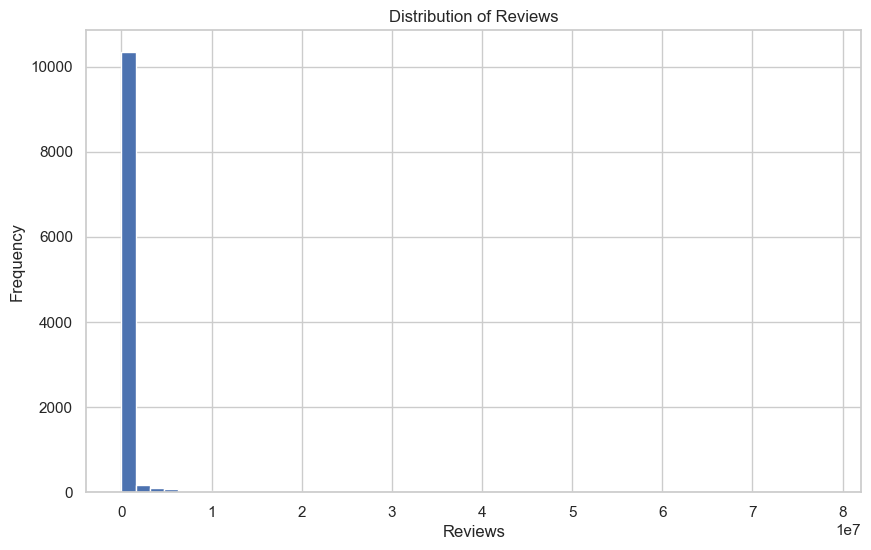

16.44842802331534


In [110]:
#Taking a look at reviews:
plt.figure(figsize=(10, 6))
plt.hist(app['Reviews'], bins=50)
plt.title('Distribution of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.show()
print(app['Reviews'].skew())

The skewness of Reviews is 16.4 which is very high hence we use log transformation to reduce it to avoid biases in data and for better model accuracy.

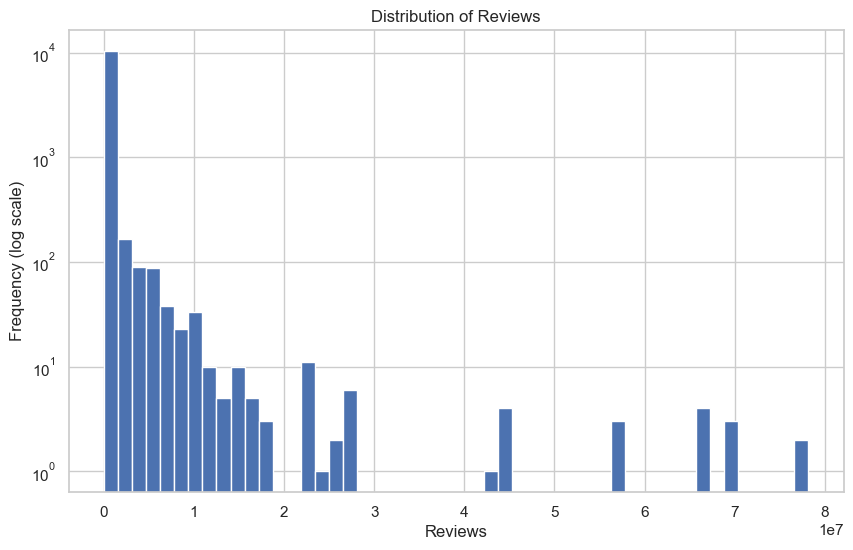

In [111]:
#Taking a look at reviews:
plt.figure(figsize=(10, 6))
plt.hist(app['Reviews'], bins=50, log = True)
plt.title('Distribution of Reviews')
plt.xlabel('Reviews')
plt.ylabel('Frequency (log scale)')
plt.show()

In [112]:
app['Log_Reviews'] = np.log(app['Reviews'] + 1)
app.head()
print(app['Log_Reviews'].skew())

-0.015676216493386044


The skewness is close to 0 as we can see above, hence it is closer to being symmetrical than asymmetrical after log transformation. Therefore we can use it for modeling.

#### 2. Combining Rating and Reviews as it could potentially mean that the app is more likely to be downloaded.

In [113]:
app['Rating_Review_Interaction'] = app['Rating'] * app['Log_Reviews']
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,5.075174,20.808213
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,6.875232,26.813405
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,11.379520,53.483743
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,12.281389,55.266250
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,6.875232,29.563498


In [114]:
print(app['Rating_Review_Interaction'].skew())

0.21119018565746714


From the above skewness we can see that the Rating_Review_Interaction is fairly symmetrical.

A high rating Review interaction number could mean that people loved the app a lot hence they took out time to write a review and to rate, or people did not like the app and they took out time to negatively review and rate. The prior has a higher possibility, as a good rating would fairly mean a good app and combined with high number of reviews would perphaps also indicate a resonably trending app.

#### 3. Taking a look at Installs to understand how to categorize them into groups:

Since installs directly impacts the likeliness to download the app, it is important to include it in a nuanced way in the pattern.

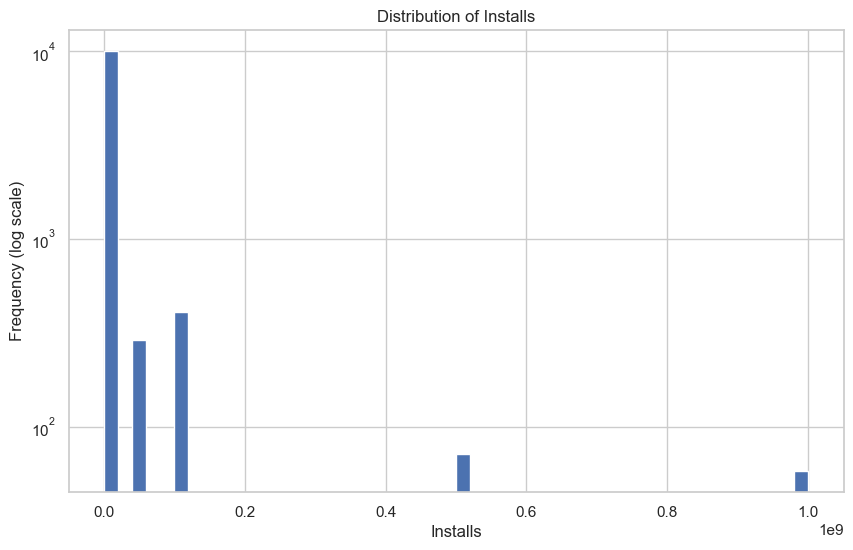

In [115]:
plt.figure(figsize=(10, 6))
plt.hist(app['Installs'], bins=50, log=True)
plt.title('Distribution of Installs')
plt.xlabel('Installs')
plt.ylabel('Frequency (log scale)')
plt.show()

In [116]:
# Displaying basic statistics
print(app['Installs'].describe())
print(app['Installs'].skew())

count    1.084000e+04
mean     1.546434e+07
std      8.502936e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64
9.572066754928612


Due to high skewness we may think to take a Threshold to be 75% considering the popular apps which would focus on the top 25% of apps by installs, resulting in a meaningful distinction between high and low likelihood for downloads

Since people will be more attracted when the number of downloads are high hence, taking only the top 25% will help in pattern may be a better idea considering highly skewed number of Installs, allowing me to focus on a subset of apps that are most relevant to the characteristics of highly likely download.

Making the pattern more complex we take another condition in deciciding, the Rating > 4.5

In [117]:
threshold = 5_000_000  # 5 million installs
app['High Number of Installs(more than 5M and rating>=4.5)'] = ((app['Installs'] >= threshold) & (app['Rating'] >= 4.5)).astype(int)
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction,High Number of Installs(more than 5M and rating>=4.5)
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,5.075174,20.808213,0
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,6.875232,26.813405,0
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,11.379520,53.483743,1
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,12.281389,55.266250,1
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,6.875232,29.563498,0


#### 4. Using Size in our model:

Another very relevant feature is Size. With good rating, reviews, it is important that the app is of reasonable size. Therefore, including size in the pattern is significant.

In [118]:
# Displaying basic statistics
print(app['Size(Mb)'].describe())
print(app['Size(Mb)'].skew())

count    9145.000000
mean       21.516165
std        22.589084
min         0.008301
25%         4.900000
50%        13.000000
75%        30.000000
max       100.000000
Name: Size(Mb), dtype: float64
1.5573154523410206


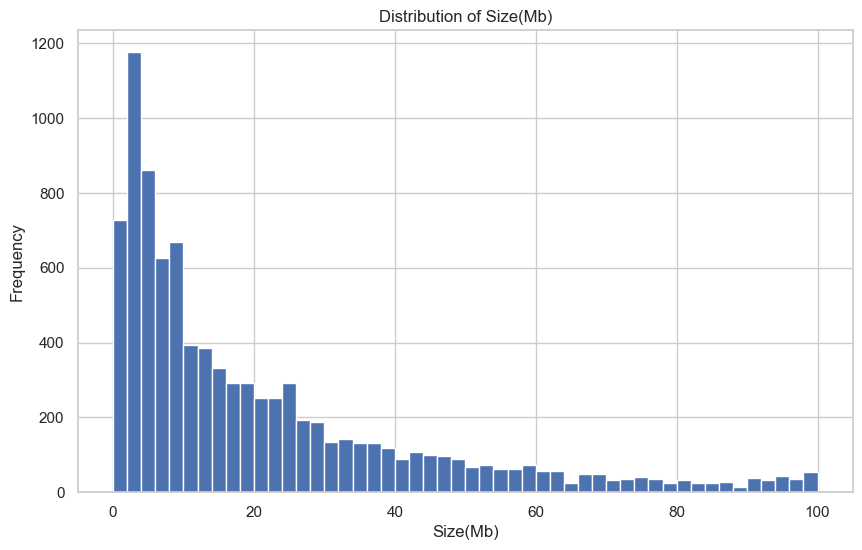

In [119]:
plt.figure(figsize=(10, 6))
plt.hist(app['Size(Mb)'], bins=50, edgecolor = 'white')
plt.title('Distribution of Size(Mb)')
plt.xlabel('Size(Mb)')
plt.ylabel('Frequency')
plt.show()

As we can see that Size as well is skewed hence we can use log transformation as well:

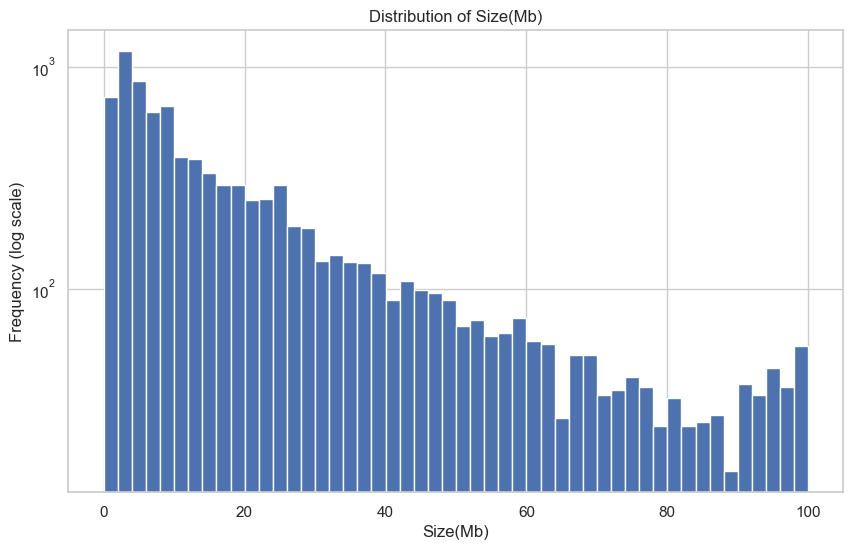

In [120]:
plt.figure(figsize=(10, 6))
plt.hist(app['Size(Mb)'], bins=50, log=True, edgecolor='white')
plt.title('Distribution of Size(Mb)')
plt.xlabel('Size(Mb)')
plt.ylabel('Frequency (log scale)')
plt.show()

Similar to what we did for installs, but here we take the threshold as the value of the 75% and below. Hence, we include apps that have size less than 30mb and to make the pattern more complex we take another condition in deciciding as above, the Rating > 3 which is a resonable rating

In [45]:
threshold = 30 
app['Size(<=30andrating>3)'] = ((app['Size(Mb)'] < threshold) & (app['Rating'] >= 3)).astype(int)
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction,High Number of Installs(more than 5M and rating>=4.5),Size(<=30andrating>3)
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,5.075174,20.808213,0,1
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,6.875232,26.813405,0,1
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,11.379520,53.483743,1,1
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,12.281389,55.266250,1,1
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,6.875232,29.563498,0,1


#### 5. Getting Composite Score!

To create a more impactful pattern, a composite score may come in handy therefore, I created one based on a four important columns:

In [46]:
#Weights for each componenet
RatingWeight = 1
RatingReviewInteractionWeight = 2
LogSizeWeight = 2
priceweight = 0.5
installsweight = 1.5
# Calculate the composite score
app['Composite_Score'] = ((RatingWeight * app['Rating']) +
    (RatingReviewInteractionWeight * app['Rating_Review_Interaction']) -
    (LogSizeWeight * app['Size(<=30andrating>3)']) + (installsweight* app['High Number of Installs(more than 5M and rating>=4.5)']))

app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction,High Number of Installs(more than 5M and rating>=4.5),Size(<=30andrating>3),Composite_Score
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,5.075174,20.808213,0,1,43.716425
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,6.875232,26.813405,0,1,55.526810
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,11.379520,53.483743,1,1,111.167486
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,12.281389,55.266250,1,1,114.532499
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,6.875232,29.563498,0,1,61.426996


We want high rating hence we have a good weight for Rating. We also want a high rating and review interaction value hance we + to the composite score, with again a good weight. Coming to the size, we want less size and it is important as people with low storage may struggle. Then we also want a low size and finally high number of installs

In [47]:
print(app['Composite_Score'].describe())
print(app['Composite_Score'].skew())

count    10841.000000
mean        64.244201
std         42.173286
min          0.000000
25%         29.835484
50%         65.525945
75%         97.044412
max        585.736681
Name: Composite_Score, dtype: float64
0.2037470744872569


### III) Dealing with NaNs and missing values:

In [48]:
for column in app.columns:
    if app[column].dtype in ['int64', 'float64']:
        median = app[column].median()
        app[column].fillna(median, inplace=True)
    else:
        mode = app[column].mode()[0]  
        app[column].fillna(mode, inplace=True)

### IV) Creating the Target Column:

In [49]:
rating_review_interaction = app['Rating_Review_Interaction'].quantile(0.75) #Have high rating-review interaction
median_rating_review_interaction = app['Rating_Review_Interaction'].quantile(0.5)#Have above medium rating review interaction
low_rating_review_interaction = app['Rating_Review_Interaction'].quantile(0.25)
# Calculate size thresholds: excessively large, under the assumption that very large apps might be less likely to be downloaded due to storage and data constraints. 
  # Median
def Likely_to_Download(row):
    if (row['Type'] == 'Free' and
        row['Rating_Review_Interaction'] > rating_review_interaction and
        row['Category'] in ['FAMILY','GAME', 'BUSINESS', 'MEDICAL', 'TOOLS'] and 
        row['Content Rating'] == 'Everyone' and
        row['Composite_Score'] > 100 and
        row['Size(<=30andrating>3)'] == 1 and
        row['High Number of Installs(more than 5M and rating>=4.5)'] == 1):
        return 'Highly Likely'
    elif (row['Type'] == 'Free' and
          row['Rating_Review_Interaction'] > median_rating_review_interaction and
          row['Size(<=30andrating>3)'] == 0 and
          row['High Number of Installs(more than 5M and rating>=4.5)'] == 0):
        return 'Likely'
    elif (row['Rating_Review_Interaction'] > low_rating_review_interaction):
        return 'Not Likely'
    else:
        return 'Disregard'
app['Likely to be Downloaded'] = app.apply(Likely_to_Download, axis=1)
app.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction,High Number of Installs(more than 5M and rating>=4.5),Size(<=30andrating>3),Composite_Score,Likely to be Downloaded
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,5.075174,20.808213,0,1,43.716425,Not Likely
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,6.875232,26.813405,0,1,55.526810,Not Likely
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,11.379520,53.483743,1,1,111.167486,Not Likely
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,12.281389,55.266250,1,1,114.532499,Not Likely
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,6.875232,29.563498,0,1,61.426996,Not Likely


In [50]:
file_path = '/Users/anushaparanjpe/Downloads/PredictionChallenge/modified_googleapp_dataset.csv'
app.to_csv(file_path, index=False)

In the highly Likely:

* The apps should be free
* The Rating_Review Interaction should be high
* In Category, 'FAMILY','GAME', 'BUSINESS', 'MEDICAL', 'TOOLS' are some of the top ones hence more apps from these categories are likely to be downloaded.
* Content Rating: Everyone, 'Everyone' has the most count and most likely to be a part of highly likely downloads.
* Composite Score > 100 as we can 75% 97.044412 hence it is a resonable approach
* row['Size(<=30andrating>3)'] == 1 is understood as less than 30 mb and rating greater than 3
* 'High Number of Installs(more than 5M and rating>=4.5)'] == 1) can be understood as well as more people are drawn when there are higher number of installs. In a similar fashion the Likely attribute was made and lastly the rest would be Not Likely

#### Taking a look at all the highly likely rows

In [51]:
app.groupby('Likely to be Downloaded').get_group('Highly Likely')

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Log_Reviews,Rating_Review_Interaction,High Number of Installs(more than 5M and rating>=4.5),Size(<=30andrating>3),Composite_Score,Likely to be Downloaded
206,206,Call Blocker,BUSINESS,4.6,188841,3.2,5000000.0,Free,0.0,Everyone,Business,21-Jun-18,1.1.13,4.0 and up,12.148666,55.883863,1,1,115.867727,Highly Likely
216,216,"IndiaMART: Search Products, Buy, Sell & Trade",BUSINESS,4.5,207372,11.0,5000000.0,Free,0.0,Everyone,Business,2-Aug-18,12.2.4,4.0 and up,12.242274,55.090235,1,1,114.180469,Highly Likely
232,232,Fast Scanner : Free PDF Scan,BUSINESS,4.5,103755,14.0,10000000.0,Free,0.0,Everyone,Business,11-Jul-18,3.9.2,4.1 and up,11.549797,51.974088,1,1,107.948175,Highly Likely
288,288,Fast Scanner : Free PDF Scan,BUSINESS,4.5,103755,14.0,10000000.0,Free,0.0,Everyone,Business,11-Jul-18,3.9.2,4.1 and up,11.549797,51.974088,1,1,107.948175,Highly Likely
1656,1656,Solitaire,GAME,4.7,254258,23.0,10000000.0,Free,0.0,Everyone,Card,1-Aug-18,2.137.0,4.1 and up,12.446109,58.496711,1,1,121.193422,Highly Likely
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,8897,DU Antivirus Security - Applock & Privacy Guard,TOOLS,4.6,436615,10.0,10000000.0,Free,0.0,Everyone,Tools,5-Jun-18,3.3.1,4.0.3 and up,12.986809,59.739323,1,1,123.578646,Highly Likely
8898,8898,DU Cleaner – Memory cleaner & clean phone cache,TOOLS,4.5,465831,8.9,10000000.0,Free,0.0,Everyone,Tools,23-Jul-18,1.5.9.9,4.0 and up,13.051580,58.732111,1,1,121.464223,Highly Likely
9393,9393,Guess The Emoji,GAME,4.5,76627,23.0,5000000.0,Free,0.0,Everyone,Word,3-Jul-18,8.16g,4.2 and up,11.246718,50.610230,1,1,105.220460,Highly Likely
9641,9641,Chess Free,GAME,4.5,1375988,15.0,50000000.0,Free,0.0,Everyone,Board,7-Jun-18,2.72,4.1 and up,14.134683,63.606075,1,1,131.212150,Highly Likely


#### ---------------------------------------------------------------------------------------------------------------
#### ---------------------------------------------------------------------------------------------------------------

### Hypothetical Situation:

##### Coming to the hypothetical Sitatuation where a Student tries to build a model using this dataset to predict the response variable: Likely to be Downloaded

In [52]:
#Using the dataset after cleaning:
student_data = app.drop(['Log_Reviews','Rating_Review_Interaction','High Number of Installs(more than 5M and rating>=4.5)','Size(<=30andrating>3)','Composite_Score'], axis = 1)
print(student_data.isna().sum())

Unnamed: 0                 0
App                        0
Category                   0
Rating                     0
Reviews                    0
Size(Mb)                   0
Installs                   0
Type                       0
Price($)                   0
Content Rating             0
Genres                     0
Last Updated               0
Current Ver                0
Android Ver                0
Likely to be Downloaded    0
dtype: int64


Looking at the missing values, the student would first think to deal with them in order to create a successful model:

In [53]:
student_data.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Likely to be Downloaded
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,Not Likely
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,Not Likely
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,Not Likely
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,Not Likely
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,Not Likely


Looking at the columns the student may resonably think that columns like Unnamed, App, Last Updated may not be of relevence, as the dataset is 5 years old.

#### Now to inspect the columns and think which columns would impact the the response column:

1. The student may start with visualizations as they help the most in understanding the dataset: The most relevant columns to the likeliness of downloading an app would be the Reviews, the Ratings, number of installs and perhaps the Price

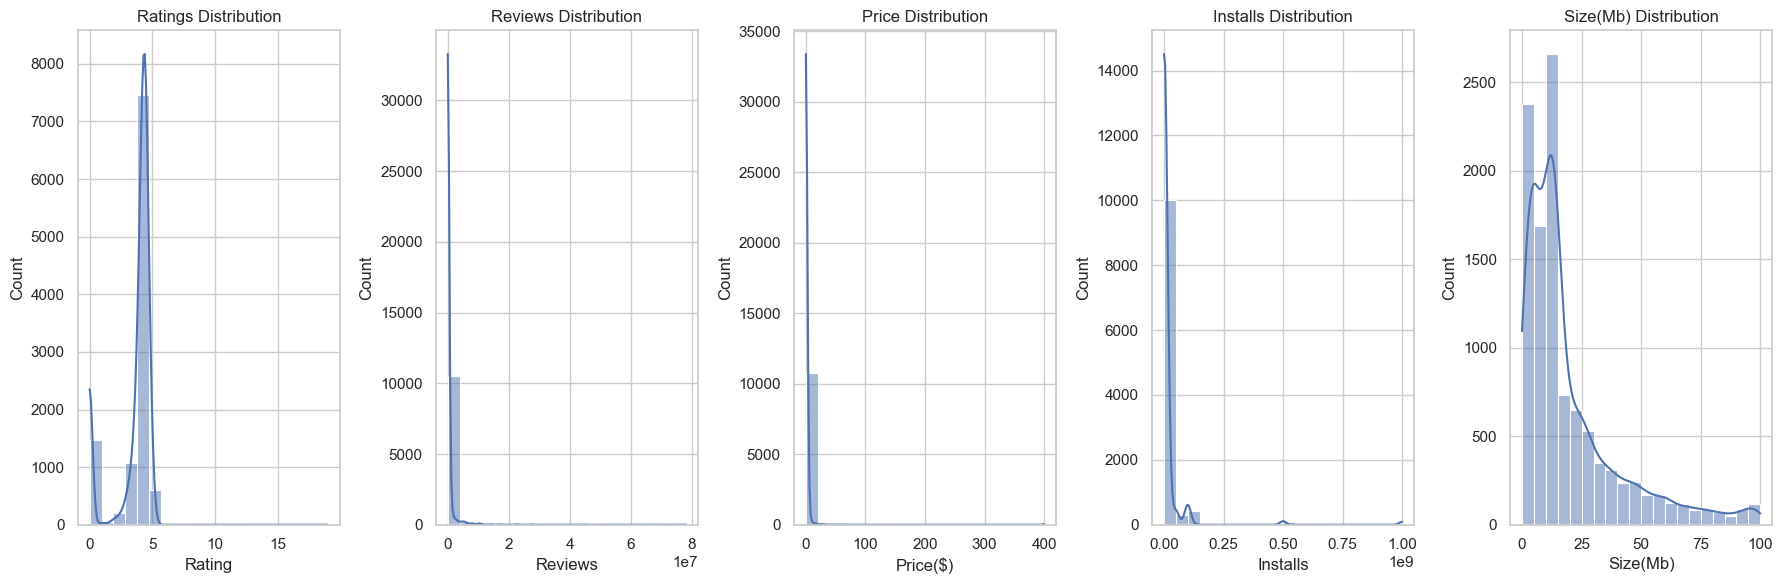

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

##Getting the histogram of each of the columns mentioned above: 'Rating', 'Reviews', 'Price', 'Installs'
fig, ax = plt.subplots(1, 5, figsize=(18, 6))
sns.histplot(student_data['Rating'].dropna(), bins=20, kde=True, ax=ax[0])
ax[0].set_title('Ratings Distribution')

sns.histplot(student_data['Reviews'], bins=20, kde=True, ax=ax[1])
ax[1].set_title('Reviews Distribution')

sns.histplot(student_data['Price($)'].dropna(), bins=20, kde=True, ax=ax[2])
ax[2].set_title('Price Distribution')

sns.histplot(student_data['Installs'].dropna(), bins=20, kde=True, ax=ax[3])
ax[3].set_title('Installs Distribution')

sns.histplot(student_data['Size(Mb)'].dropna(), bins=20, kde=True, ax=ax[4])
ax[4].set_title('Size(Mb) Distribution')

plt.tight_layout()
plt.show()

#### From the above plots it may hint the student that the columns Reviews, Price and Installs are highly skewed. Hence, the student may attempt to individually check these columns.

i) Reviews:

In [55]:
print(student_data['Reviews'].describe())
print(student_data['Reviews'].skew())

count    1.084100e+04
mean     4.443887e+05
std      2.927728e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.479800e+04
max      7.815831e+07
Name: Reviews, dtype: float64
16.44842802331534


In [56]:
student_data['Log_Reviews'] = np.log(student_data['Reviews'] + 1)
print(student_data['Log_Reviews'].skew())
student_data.head()

-0.015676216493386044


,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Likely to be Downloaded,Log_Reviews
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,Not Likely,5.075174
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,Not Likely,6.875232
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,Not Likely,11.379520
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,Not Likely,12.281389
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,Not Likely,6.875232


ii) Price:

In [57]:
print(student_data['Price($)'].describe())
print(student_data['Price($)'].skew())

count    10841.000000
mean         1.027273
std         15.948971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price($), dtype: float64
23.708489758783823


The above value of skewness is very high and portrays the following:

1. 75% of the observations have values of 0 or higher indicating that a large amount of the dataset consists of zeros.

2. The value at max is 400, highlighting the presence of extreme values or outliers that affect the mean and the standard deviation.

Hence using the price column does not sound reasonable.

Therefore, instead of Price the student may use the Type column for modeling:

In [58]:
student_data['Free_apps'] = student_data['Type'].apply(lambda x: 1 if x == 'Free' else 0)
student_data.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Likely to be Downloaded,Log_Reviews,Free_apps
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,Not Likely,5.075174,1
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,Not Likely,6.875232,1
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,Not Likely,11.379520,1
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,Not Likely,12.281389,1
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,Not Likely,6.875232,1


iii) Installs:

In [59]:
print(student_data['Installs'].describe())
print(student_data['Installs'].skew())

count    1.084100e+04
mean     1.546292e+07
std      8.502557e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64
9.572514359654384


Through this it can be seen that 75 percent of the data in Installs column has values 5M or higher. But with this information it may not come to the student's mind to create a column based on this in order to get the top 25 percent or the popular apps. Although it may clue the student to by seeing the number at 75%.

The student may set a general threshold:

In [60]:
student_data['High Number of Installs'] = (student_data['Installs'] > 1e6).astype(int)
student_data.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Likely to be Downloaded,Log_Reviews,Free_apps,High Number of Installs
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,Not Likely,5.075174,1,0
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,Not Likely,6.875232,1,0
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,Not Likely,11.379520,1,1
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,Not Likely,12.281389,1,1
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,Not Likely,6.875232,1,0


iv) Size:

In [61]:
print(student_data['Size(Mb)'].describe())
print(student_data['Size(Mb)'].skew())

count    10841.000000
mean        20.183870
std         20.976262
min          0.008301
25%          5.900000
50%         13.000000
75%         26.000000
max        100.000000
Name: Size(Mb), dtype: float64
1.8208780997676697


The student may apply log transformation to Size:

In [62]:
student_data['Log_Size(Mb)'] = np.log(student_data['Size(Mb)'] + 1)
print(student_data['Log_Size(Mb)'].skew())
student_data.head()

-0.1557111093158083


,Unnamed: 0,App,Category,Rating,Reviews,Size(Mb),Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver,Likely to be Downloaded,Log_Reviews,Free_apps,High Number of Installs,Log_Size(Mb)
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up,Not Likely,5.075174,1,0,2.995732
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up,Not Likely,6.875232,1,0,2.708050
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up,Not Likely,11.379520,1,1,2.272126
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up,Not Likely,12.281389,1,1,3.258097
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up,Not Likely,6.875232,1,0,1.335001


Now the skewness is very low hence it can be used of modeling

#### With this current information the student may start creating models:

Getting the data ready to create models:

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features and Target variable
le = LabelEncoder()
X = pd.get_dummies(student_data.drop(columns=['Likely to be Downloaded', 'App', 'Category',  'Content Rating', 'Genres', 'Last Updated']),drop_first=True)#dropping the target variable and using one hot encoding
y = student_data['Likely to be Downloaded']
y = le.fit_transform(y)
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((8672, 2828), (2169, 2828), (8672,), (2169,))

#### Model 1: Using Logistic Regression: Baseline

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

# Evaluating the model
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_f1 = f1_score(y_test, y_pred, average = 'macro')

log_reg_accuracy, log_reg_f1

(0.8713692946058091, 0.7171048233658635)

#### Model 2: Using Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
#X_train_filled = np.nan_to_num(X_train_scaled, nan=np.nanmedian(X_train_scaled, axis=0))
#X_test_filled = np.nan_to_num(X_test_scaled, nan=np.nanmedian(X_test_scaled, axis=0))

# Predicting on the test set
y_pred_rf = rf.predict(X_test_scaled)

# Evaluating the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average = 'macro')

rf_accuracy, rf_f1

(0.9585062240663901, 0.7963370758378898)

#### Therefore, if the student is able to find the key points of skewness and log transformations, it is possible to get a good prediction using random forest model. But in order to get a greater accuracy the student will need the Composite Score. 